In [69]:
import smote_variants as sv
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from collections import Counter
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

[FeatureSelection] 选择 top-8 特征： ['gc_13', 'x_c', 'gc_18', 'gc_21', 'z_21', 'age', 'ESI', 'GC']
[FeatureSelection] 特征重要性（前6）：
 gc_13    0.127294
x_c      0.117290
gc_18    0.112395
gc_21    0.097027
z_21     0.077626
age      0.065048
dtype: float64
=== 原始标签组合分布 ===
_label_tuple
(0, 0, 0)    342
(0, 1, 0)     21
(1, 1, 0)      9
(1, 0, 0)      8
(0, 0, 1)      5
(1, 0, 1)      1
(0, 1, 1)      1
Name: count, dtype: int64
[MLSMOTE] 使用目标样本数 target_count = 21（针对异常组合）
[DEBUG MLSMOTE] ref_idx=1, neigh_idx=3, ref_label=[1 1 0], neigh_label=[1 1 0], new_label=[1 1 0]
[DEBUG MLSMOTE] ref_idx=3, neigh_idx=7, ref_label=[1 1 0], neigh_label=[1 1 0], new_label=[1 1 0]
[DEBUG MLSMOTE] ref_idx=1, neigh_idx=6, ref_label=[1 1 0], neigh_label=[1 1 0], new_label=[1 1 0]
[MLSMOTE] 组合 (1, 1, 0) 当前 9 -> 生成 12
[DEBUG MLSMOTE] ref_idx=4, neigh_idx=1, ref_label=[1 0 0], neigh_label=[1 0 0], new_label=[1 0 0]
[DEBUG MLSMOTE] ref_idx=1, neigh_idx=2, ref_label=[1 0 0], neigh_label=[1 0 0], new_label=[1 0 0]
[DEBU

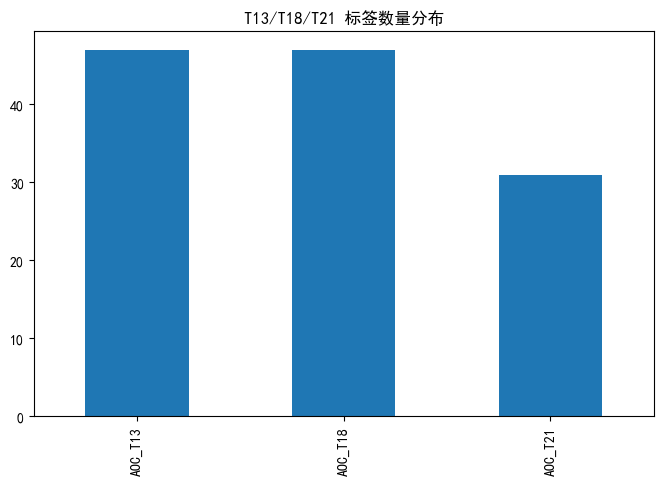

In [75]:
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


def nearest_neighbour(X, n_neighbors=5):
    X_np = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
    n = X_np.shape[0]
    if n == 0:
        return np.empty((0, 0), dtype=int)
    k = min(n_neighbors + 1, n)  # +1 to include self
    nbs = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='kd_tree').fit(X_np)
    _, indices = nbs.kneighbors(X_np)
    return indices


def jaccard_similarity(y1, y2):
    intersection = np.sum(np.logical_and(y1, y2))
    union = np.sum(np.logical_or(y1, y2))
    if union == 0:
        return 1.0
    return intersection / union


def MLSMOTE_multilabel(X, y, n_sample, n_neighbors=5, add_noise=True):
    """
    Standard MLSMOTE on a subset X,y (len>=2). Returns X_new, y_new (DataFrames).
    Label strategy: union(ref, neighbour).
    """
    if len(X) < 2:
        # Should not call this for singletons; handle outside
        return pd.DataFrame(columns=X.columns), pd.DataFrame(columns=y.columns)

    indices2 = nearest_neighbour(X, n_neighbors=n_neighbors)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    new_y = np.zeros((n_sample, y.shape[1]))

    global_range = (X.max() - X.min()).replace(0, 1e-6)

    for i in range(n_sample):
        reference = random.randint(0, n - 1)
        neigh_indices = indices2[reference, :].tolist()
        neigh_indices = [idx for idx in neigh_indices if idx != reference]

        if not neigh_indices:
            candidates = list(range(n))
            candidates.remove(reference)
            neighbour = random.choice(candidates)
        else:
            sims = [jaccard_similarity(y.iloc[reference].values, y.iloc[nb].values) for nb in neigh_indices]
            max_sim = max(sims)
            best_idxs = [neigh_indices[idx] for idx, s in enumerate(sims) if s == max_sim]
            neighbour = random.choice(best_idxs)

        ratio = random.random()
        gap = X.iloc[neighbour, :].values - X.iloc[reference, :].values

        if add_noise:
            local_scale = np.abs(X.iloc[reference, :].values - X.iloc[neighbour, :].values)
            std = 0.01 * np.where(local_scale == 0, global_range.values * 0.01, local_scale)
            perturb = np.random.normal(loc=0.0, scale=std, size=X.shape[1])
        else:
            perturb = np.zeros(X.shape[1])

        new_x = X.iloc[reference, :].values + ratio * gap + perturb
        # clip to original feature range to avoid极端外推
        new_x = np.minimum(np.maximum(new_x, X.min().values), X.max().values)

        new_X[i, :] = new_x
        y_ref = y.iloc[reference].values.astype(int)
        y_nei = y.iloc[neighbour].values.astype(int)
        new_label = np.logical_or(y_ref, y_nei).astype(int)
        new_y[i, :] = new_label

        if i < 3:
            print(f"[DEBUG MLSMOTE] ref_idx={reference}, neigh_idx={neighbour}, ref_label={y_ref}, neigh_label={y_nei}, new_label={new_label}")

    new_X_df = pd.DataFrame(new_X, columns=X.columns)
    new_y_df = pd.DataFrame(new_y.astype(int), columns=y.columns)
    return new_X_df, new_y_df


def generate_from_single_sample(single_row, other_df, n_generate, feature_cols, label_cols, n_neighbors=5, add_noise=True):
    """
    为单样本组合生成 n_generate 个合成样本：
    - single_row: DataFrame 单行（含 feature & label）
    - other_df: DataFrame 包含所有其他异常样本（含 feature & label）
    策略：每次选一个最相似的其他异常样本（先按标签 Jaccard，再按特征距离）做插值。
    """
    X_ref = single_row[feature_cols].iloc[0].values.astype(float)
    y_ref = single_row[label_cols].iloc[0].values.astype(int)

    if other_df.shape[0] == 0:
        # 没有其他异常可用，退回：复制 + 小扰动
        new_Xs, new_ys = [], []
        global_scale = (single_row[feature_cols].max() - single_row[feature_cols].min())
        for _ in range(n_generate):
            perturb = np.random.normal(0, 0.01 * (global_scale.replace(0, 1e-6).values))
            new_x = np.clip(X_ref + perturb, single_row[feature_cols].min().values, single_row[feature_cols].max().values)
            new_Xs.append(new_x)
            new_ys.append(y_ref)
        return pd.DataFrame(new_Xs, columns=feature_cols), pd.DataFrame(np.array(new_ys).astype(int), columns=label_cols)

    # 计算其他异常样本的标签相似度与特征距离
    feats = other_df[feature_cols].values.astype(float)
    labels = other_df[label_cols].values.astype(int)

    new_Xs, new_ys = [], []
    for _ in range(n_generate):
        # jaccard scores
        j_scores = np.array([jaccard_similarity(y_ref, lab) for lab in labels])
        max_j = j_scores.max()
        candidates_idx = np.where(j_scores == max_j)[0]
        # 若多个相同 jaccard，按特征距离选最近
        if len(candidates_idx) > 1:
            dists = np.linalg.norm(feats[candidates_idx] - X_ref, axis=1)
            choose_idx = candidates_idx[np.argmin(dists)]
        else:
            choose_idx = candidates_idx[0]

        neighbor_feat = feats[choose_idx]
        neighbor_label = labels[choose_idx]

        ratio = random.random()
        gap = neighbor_feat - X_ref

        if add_noise:
            local_scale = np.abs(X_ref - neighbor_feat)
            std = 0.01 * np.where(local_scale == 0, np.std(feats, axis=0) * 0.01, local_scale)
            perturb = np.random.normal(0, std)
        else:
            perturb = np.zeros_like(X_ref)

        new_x = X_ref + ratio * gap + perturb
        # clip 到全体其他异常的范围，防止极端
        col_min = np.minimum(single_row[feature_cols].min().values, other_df[feature_cols].min().values)
        col_max = np.maximum(single_row[feature_cols].max().values, other_df[feature_cols].max().values)
        new_x = np.minimum(np.maximum(new_x, col_min), col_max)

        new_label = np.logical_or(y_ref, neighbor_label).astype(int)

        new_Xs.append(new_x)
        new_ys.append(new_label)

    return pd.DataFrame(new_Xs, columns=feature_cols), pd.DataFrame(np.array(new_ys).astype(int), columns=label_cols)


# 需要的额外导入（放在文件头）
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain

# ---------- 新增：多标签特征选择函数 ----------
def feature_selection_multilabel(X, y, method='rf', n_features=None,
                                 random_state=42, rf_n_estimators=200):
    """
    多标签特征选择（基于 RandomForest + ClassifierChain）。
    仅统计每个链中对原始特征部分的 feature_importances_。
    """
    if method != 'rf':
        raise ValueError("目前只支持 method='rf'")

    if X.shape[1] == 0:
        return [], pd.Series(dtype=float)

    rf = RandomForestClassifier(n_estimators=rf_n_estimators, random_state=random_state, n_jobs=-1)
    chain = ClassifierChain(rf)
    chain.fit(X, y)

    n_features_total = X.shape[1]
    all_importances = []

    for est in chain.estimators_:
        # 注意：后续链的输入是 [原始X, 已预测标签]，我们只取前 n_features_total 部分
        imp = getattr(est, "feature_importances_", None)
        if imp is not None:
            if len(imp) >= n_features_total:
                all_importances.append(imp[:n_features_total])
            else:
                # 理论上不会发生，但加保险
                pad = np.zeros(n_features_total)
                pad[:len(imp)] = imp
                all_importances.append(pad)

    if not all_importances:
        print("[FeatureSelection] 所有子模型均无 feature_importances_，返回空列表。")
        return [], pd.Series(dtype=float)

    mean_imps = np.mean(np.vstack(all_importances), axis=0)
    feat_series = pd.Series(mean_imps, index=X.columns).sort_values(ascending=False)

    if n_features is None:
        n_features = max(1, X.shape[1] // 2)
    n_features = min(n_features, X.shape[1])
    selected = feat_series.iloc[:n_features].index.tolist()

    print("[FeatureSelection] 选择 top-%d 特征：" % n_features, selected)
    print("[FeatureSelection] 特征重要性（前6）：\n", feat_series.head(6))

    return selected, feat_series


def MLSMOTE_balance_by_labelset_with_singleton_support(X, y,
                                                       min_samples=1,
                                                       target_count=None,
                                                       n_neighbors=5,
                                                       add_noise=True,
                                                       max_ratio=5,
                                                       select_features=False,
                                                       n_selected_features=None,
                                                       select_method='rf',
                                                       rf_n_estimators=200,
                                                       selection_random_state=RANDOM_STATE):
    """
    与原函数行为一致，但新增 select_features 参数：
    - select_features: 是否先做特征选择（仅在传入训练集时使用！）
    - n_selected_features: 若不为 None，则选择固定数量特征；否则默认 top50%。
    返回：X_res (DataFrame only selected features), y_res (DataFrame), selected_features (list or None)
    """

    # 复制输入以免修改外部变量
    X = X.reset_index(drop=True).copy()
    y = y.reset_index(drop=True).copy()

    # 1) 特征选择（仅在用户开启时）
    selected_features = None
    if select_features:
        selected_features, feat_importances = feature_selection_multilabel(
            X, y,
            method=select_method,
            n_features=n_selected_features,
            random_state=selection_random_state,
            rf_n_estimators=rf_n_estimators
        )
        # 用选出的特征裁剪 X
        if len(selected_features) == 0:
            print("[FeatureSelection] 未选中任何特征，退回全特征。")
            selected_features = X.columns.tolist()
        X = X[selected_features].reset_index(drop=True)

    label_cols = y.columns.tolist()
    feature_cols = X.columns.tolist()
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    df['_label_tuple'] = df[label_cols].apply(lambda row: tuple(int(x) for x in row), axis=1)

    labelset_counts = df['_label_tuple'].value_counts()
    print("=== 原始标签组合分布 ===")
    print(labelset_counts)

    healthy_label = tuple([0] * len(label_cols))
    anomaly_counts = labelset_counts.drop(labels=[healthy_label], errors='ignore')
    if anomaly_counts.shape[0] == 0:
        print("[MLSMOTE] 未检测到异常组合，返回原始数据。")
        X_res = X.copy()
        y_res = y.copy()
        return X_res, y_res, selected_features

    if target_count is None:
        target_count = int(anomaly_counts.max())
    print(f"[MLSMOTE] 使用目标样本数 target_count = {target_count}（针对异常组合）")
    all_new = []

    df_anomalies = df[df['_label_tuple'] != healthy_label].reset_index(drop=True)

    for labelset, count in labelset_counts.items():
        if labelset == healthy_label:
            continue
        count = int(count)
        allowed_final = min(target_count, int(max(1, count * max_ratio)))
        n_to_generate = max(0, allowed_final - count)

        if n_to_generate <= 0:
            continue

        if count >= 2:
            df_sub = df[df['_label_tuple'] == labelset].reset_index(drop=True)
            X_sub = df_sub[feature_cols]
            y_sub = df_sub[label_cols]
            X_new, y_new = MLSMOTE_multilabel(X_sub, y_sub, n_to_generate, n_neighbors=n_neighbors, add_noise=add_noise)
            if not X_new.empty:
                df_new = pd.concat([X_new.reset_index(drop=True), y_new.reset_index(drop=True)], axis=1)
                df_new['_label_tuple'] = [labelset] * len(df_new)
                all_new.append(df_new)
            print(f"[MLSMOTE] 组合 {labelset} 当前 {count} -> 生成 {len(X_new)}")
        else:
            df_sub = df[df['_label_tuple'] == labelset].reset_index(drop=True)
            df_other = df_anomalies[df_anomalies['_label_tuple'] != labelset].reset_index(drop=True)
            # 这里传入 feature_cols、label_cols（feature_cols 已根据选择裁剪）
            X_new, y_new = generate_from_single_sample(df_sub, df_other, n_to_generate, feature_cols, label_cols, n_neighbors=n_neighbors, add_noise=add_noise)
            if not X_new.empty:
                df_new = pd.concat([X_new.reset_index(drop=True), y_new.reset_index(drop=True)], axis=1)
                df_new['_label_tuple'] = [labelset] * len(df_new)
                all_new.append(df_new)
            print(f"[MLSMOTE] 单样本组合 {labelset} 当前 {count} -> 生成 {len(X_new)}")

    if all_new:
        df_new_all = pd.concat(all_new, axis=0).reset_index(drop=True)
        df_combined = pd.concat([df, df_new_all], axis=0).reset_index(drop=True)
    else:
        df_combined = df.copy()

    cols_keep = feature_cols + label_cols
    df_combined = df_combined[cols_keep].drop_duplicates().reset_index(drop=True)
    X_res = df_combined[feature_cols].reset_index(drop=True)
    y_res = df_combined[label_cols].astype(int).reset_index(drop=True)

    print("\n=== 平衡后标签组合分布 ===")
    print(y_res.apply(lambda row: tuple(int(x) for x in row), axis=1).value_counts())

    return X_res, y_res, selected_features




if __name__ == "__main__":
    df_pw = pd.read_excel("girl.xlsx")
    feature_cols = ['age', 'pw_bmi', 'GC', 'z_13', 'z_18', 'z_21',
                    'x_z', 'x_c', 'gc_13', 'gc_18', 'gc_21',
                    'pregnancies_times', 'ORS_B', 'ESI']
    label_cols = ['AOC_T13', 'AOC_T18', 'AOC_T21']

    X = df_pw[feature_cols]
    y = df_pw[label_cols]

    train_xval, test_x, train_yval, test_y = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    train_x, X_val, train_y, y_val = train_test_split(train_xval, train_yval, test_size=0.2, random_state=RANDOM_STATE)

    train_x_res, train_y_res, selected_feats = MLSMOTE_balance_by_labelset_with_singleton_support(
        train_x, train_y,
        min_samples=1,
        target_count=None,
        n_neighbors=5,
        add_noise=True,
        max_ratio=5,
        select_features=True,        # 开启特征选择
        n_selected_features=8,       # 选择 top-8 特征（你可以根据验证调整）
        select_method='rf',
        rf_n_estimators=300,
        selection_random_state=RANDOM_STATE
    )
    
    # 之后对训练数据标准化（仅对被选的特征）
    
    scaler = StandardScaler()
    train_x_res_scaled = scaler.fit_transform(train_x_res)         # 训练集 fit_transform
    # 对验证/测试集做同样的特征裁剪和 transform
    test_x_selected = test_x[selected_feats]                       # 同样只保留被选特征    
    train_x_selected = train_x[selected_feats]                     # 原始训练集裁剪特征
    train_x_selected = scaler.fit_transform(train_x_selected)
    test_x_selected = scaler.transform(test_x_selected)

    print("\n=== 平衡后单标签数量 ===")
    print(train_y_res.sum())

    print("\n健康样本数:", (train_y_res.sum(axis=1) == 0).sum())
    print("异常样本数:", (train_y_res.sum(axis=1) > 0).sum())

    # 可视化
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    pd.DataFrame(train_y_res, columns=label_cols).sum(axis=0).plot(kind='bar', title='T13/T18/T21 标签数量分布')
    plt.show()


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ------------------ 多标签评估函数 ------------------
def evaluate_multilabel(y_true, y_pred):
    metrics = {
        "Hamming Loss": hamming_loss(y_true, y_pred),
        "Subset Accuracy": accuracy_score(y_true, y_pred),
        "Precision (micro)": precision_score(y_true, y_pred, average='micro', zero_division=0),
        "Recall (micro)": recall_score(y_true, y_pred, average='micro', zero_division=0),
        "F1-score (micro)": f1_score(y_true, y_pred, average='micro', zero_division=0),
        "Precision (macro)": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "F1-score (macro)": f1_score(y_true, y_pred, average='macro', zero_division=0),
    }
    return metrics

# ------------------ 改进版 MLKNN：距离加权 + 局部先验校正 ------------------
class MLKNN_WeightedPrior:
    def __init__(self, train_x, train_y, k=10, s=1,
                 distance_weight=True, prior_correction=True, prior_alpha=0.1, sigma=None):
        """
        train_x: numpy array or pd.DataFrame
        train_y: numpy array or pd.DataFrame (binary labels 0/1)
        k: neighbors
        s: smooth parameter for Laplace smoothing in Peh
        distance_weight: whether to use distance weighting for neighbor contribution
        prior_correction: whether to adjust global prior Ph1 by local prior
        prior_alpha: interpolation factor between global prior and local prior (0..1)
        sigma: Gaussian kernel width; if None estimate per query as median distance (fallback)
        """
        self.k = int(k)
        self.s = s
        self.distance_weight = bool(distance_weight)
        self.prior_correction = bool(prior_correction)
        self.prior_alpha = float(prior_alpha)
        self.sigma = sigma  # can be None
        self.train_x = np.array(train_x)
        self.train_y = np.array(train_y).astype(int)
        self.label_num = self.train_y.shape[1]
        self.train_data_num = self.train_x.shape[0]

        # Prior and conditional probability tables (same shape as classical MLkNN)
        self.Ph1 = np.zeros(self.label_num)
        self.Ph0 = np.zeros(self.label_num)
        self.Peh1 = np.zeros((self.label_num, self.k + 1))
        self.Peh0 = np.zeros((self.label_num, self.k + 1))

        # prepare nearest neighbors structure
        self.nbrs = NearestNeighbors(metric='euclidean').fit(self.train_x)

    def train(self):
        # 1) 全局先验
        for i in range(self.label_num):
            cnt = np.sum(self.train_y[:, i])
            self.Ph1[i] = (self.s + cnt) / (self.s * 2 + self.train_data_num)
            self.Ph0[i] = 1.0 - self.Ph1[i]

        # 2) 条件概率 Peh1/Peh0: 对每个训练样本取其 k 邻居并统计邻居中标签为1的个数
        for i in range(self.label_num):
            c1 = np.zeros(self.k + 1, dtype=float)
            c0 = np.zeros(self.k + 1, dtype=float)
            for idx in range(self.train_data_num):
                # note: kneighbors returns self-point included if present; but using training point as query includes itself;
                # classical MLkNN counts neighbors excluding self — we keep consistency by requesting k+1 and removing itself if appears.
                dists, inds = self.nbrs.kneighbors([self.train_x[idx]], n_neighbors=self.k + 1)
                inds = inds[0].tolist()
                # remove self index if present
                if idx in inds:
                    inds.remove(idx)
                # if after removal we have >k keep first k, otherwise use as many as available
                inds = inds[:self.k]
                temp = int(np.sum(self.train_y[inds, i]))
                if self.train_y[idx, i] == 1:
                    c1[temp] += 1
                else:
                    c0[temp] += 1
            # Laplace-smoothed conditional probabilities
            denom1 = (self.s * (self.k + 1) + np.sum(c1))
            denom0 = (self.s * (self.k + 1) + np.sum(c0))
            for cnt in range(self.k + 1):
                self.Peh1[i, cnt] = (self.s + c1[cnt]) / denom1
                self.Peh0[i, cnt] = (self.s + c0[cnt]) / denom0

    def _compute_weights(self, distances):
        # distances: 1D array of length k (or <=k)
        # use Gaussian kernel weights; if sigma is None, fallback to median(distances) or 1e-3
        if not self.distance_weight:
            return np.ones_like(distances, dtype=float)
        if self.sigma is None:
            sigma = np.median(distances) if np.median(distances) > 1e-6 else (np.mean(distances) + 1e-6)
        else:
            sigma = self.sigma
        # Gaussian kernel on Euclidean distance; larger dist -> smaller weight
        w = np.exp(- (distances ** 2) / (2.0 * (sigma ** 2) + 1e-12))
        # avoid all-zeros
        if w.sum() == 0:
            w = np.ones_like(w)
        return w

    def predict(self, test_x):
        test_x = np.array(test_x)
        n_test = test_x.shape[0]
        y_pred = np.zeros((n_test, self.label_num), dtype=int)

        # for each test sample, find neighbors, compute weighted label sum & local prior, then decide
        for t in range(n_test):
            dists, inds = self.nbrs.kneighbors([test_x[t]], n_neighbors=self.k + 1)
            inds = inds[0].tolist()
            dists = dists[0]
            # Remove self if present (defensive, though test point not in train generally)
            # keep first k neighbors after removal
            if len(inds) > 0 and inds[0] == t:
                inds = inds[1:]
                dists = dists[1:]
            inds = inds[:self.k]
            dists = dists[:len(inds)]
            if len(inds) == 0:
                # fallback: predict all zeros if no neighbors
                continue

            weights = self._compute_weights(np.array(dists))
            weights = weights[:len(inds)]
            wsum = np.sum(weights) if np.sum(weights) > 0 else 1.0

            for label_idx in range(self.label_num):
                neighbor_labels = self.train_y[inds, label_idx]  # 0/1 array
                # weighted proportion of positive labels among neighbors
                p_local = float(np.sum(weights * neighbor_labels) / wsum)

                # adjusted prior: interpolate between global prior and local prior
                if self.prior_correction:
                    Ph1_adj = (1.0 - self.prior_alpha) * self.Ph1[label_idx] + self.prior_alpha * p_local
                    Ph0_adj = 1.0 - Ph1_adj
                else:
                    Ph1_adj = self.Ph1[label_idx]
                    Ph0_adj = self.Ph0[label_idx]

                # Map weighted positive mass to an integer count for Peh lookup
                # scale = expected count = p_local * k_effective
                k_eff = max(1, len(inds))
                expected_count = p_local * k_eff
                cnt_idx = int(round(expected_count))
                cnt_idx = min(max(0, cnt_idx), self.k)  # ensure in [0,k]

                # Bayes decision with adjusted prior
                prob1 = Ph1_adj * self.Peh1[label_idx, cnt_idx]
                prob0 = Ph0_adj * self.Peh0[label_idx, cnt_idx]

                if prob1 > prob0:
                    y_pred[t, label_idx] = 1
                else:
                    y_pred[t, label_idx] = 0

        return y_pred

# ------------------ 主流程（网格搜索 + 保存） ------------------
if __name__ == "__main__":

    # === 超参数列表 ===
    k_list = [3, 4, 5, 7, 9]
    s_list = [1, 2, 3, 4, 5]
    prior_alphas = [0.0, 0.3, 0.6, 0.9,1.0]   # 0.0 = 不使用局部先验，1.0 = 完全使用局部先验
    best_score = -1.0
    best_entry = None

    # ---------- 有 MLSMOTE 训练数据 ----------
    print("=== 运行：MLKNN (有 MLSMOTE) 网格搜索 ===")
    best_model_mls = None
    best_pred_mls = None
    best_metrics_mls = None

    for k in k_list:
        for s in s_list:
            for alpha in prior_alphas:
                model = MLKNN_WeightedPrior(train_x_res_scaled, train_y_res.values,
                                            k=k, s=s, distance_weight=True,
                                            prior_correction=True, prior_alpha=alpha, sigma=None)
                model.train()
                y_pred = model.predict(test_x_selected)
                metrics = evaluate_multilabel(test_y.values, y_pred)
                f1m = metrics["F1-score (micro)"]
                print(f"[MLSMOTE] k={k}, s={s}, alpha={alpha:.2f} -> Hamming={metrics['Hamming Loss']:.4f}, F1m={f1m:.4f}")
                # 以 F1-micro 为主要选取依据（可根据需要改）
                if f1m > best_score:
                    best_score = f1m
                    best_model_mls = model
                    best_pred_mls = y_pred
                    best_metrics_mls = metrics
                    best_entry = ("mls", k, s, alpha)

    print("\n=== 最优（有MLSMOTE）参数与指标 ===")
    print("参数 (mode,k,s,alpha):", best_entry)
    for k, v in best_metrics_mls.items():
        print(f"{k}: {v:.4f}")

    # 保存
    os.makedirs('mlknn_parameter_data', exist_ok=True)
    param_filepath = os.path.join('mlknn_parameter_data', 'mlknn_params_weighted_prior.npz')
    np.savez_compressed(
        param_filepath,
        Ph1=best_model_mls.Ph1,
        Ph0=best_model_mls.Ph0,
        Peh1=best_model_mls.Peh1,
        Peh0=best_model_mls.Peh0,
        k=np.array([best_model_mls.k]),
        s=np.array([best_model_mls.s]),
        prior_alpha=np.array([best_model_mls.prior_alpha])
    )
    print(f"[saved] MLKNN(mls) 参数 -> {param_filepath}")

    exper_path = os.path.join('mlknn_parameter_data', 'mlknn_experiment_weighted_prior.npz')
    np.savez_compressed(
        exper_path,
        predict=best_pred_mls,
        y_true=test_y.values,
        metrics=best_metrics_mls
    )
    print(f"[saved] MLKNN(mls) 实验结果 -> {exper_path}")

    # ---------- 无 MLSMOTE 对照 ----------
    print("\n=== 运行：MLKNN (无 MLSMOTE) 网格搜索 ===")
    best_model_nomls = None
    best_pred_nomls = None
    best_metrics_nomls = None
    best_score_nomls = -1.0
    best_entry_nomls = None

    for k in k_list:
        for s in s_list:
            for alpha in prior_alphas:
                model = MLKNN_WeightedPrior(train_x_selected, train_y.values,
                                            k=k, s=s, distance_weight=True,
                                            prior_correction=True, prior_alpha=alpha, sigma=None)
                model.train()
                y_pred = model.predict(test_x_selected)
                metrics = evaluate_multilabel(test_y.values, y_pred)
                f1m = metrics["F1-score (micro)"]
                print(f"[No-MLSMOTE] k={k}, s={s}, alpha={alpha:.2f} -> Hamming={metrics['Hamming Loss']:.4f}, F1m={f1m:.4f}")
                if f1m > best_score_nomls:
                    best_score_nomls = f1m
                    best_model_nomls = model
                    best_pred_nomls = y_pred
                    best_metrics_nomls = metrics
                    best_entry_nomls = ("nomls", k, s, alpha)

    print("\n=== 最优（无MLSMOTE）参数与指标 ===")
    print("参数 (mode,k,s,alpha):", best_entry_nomls)
    for k, v in best_metrics_nomls.items():
        print(f"{k}: {v:.4f}")

    # 保存 noml
    os.makedirs('nomlknn_parameter_data', exist_ok=True)
    param_filepath2 = os.path.join('nomlknn_parameter_data', 'nomlknn_params_weighted_prior.npz')
    np.savez_compressed(
        param_filepath2,
        Ph1=best_model_nomls.Ph1,
        Ph0=best_model_nomls.Ph0,
        Peh1=best_model_nomls.Peh1,
        Peh0=best_model_nomls.Peh0,
        k=np.array([best_model_nomls.k]),
        s=np.array([best_model_nomls.s]),
        prior_alpha=np.array([best_model_nomls.prior_alpha])
    )
    print(f"[saved] MLKNN(nomls) 参数 -> {param_filepath2}")

    exper_path2 = os.path.join('nomlknn_parameter_data', 'nomlknn_experiment_weighted_prior.npz')
    np.savez_compressed(
        exper_path2,
        predict=best_pred_nomls,
        y_true=test_y.values,
        metrics=best_metrics_nomls
    )
    print(f"[saved] MLKNN(noml) 实验结果 -> {exper_path2}")

    # 最后打印对比 summary
    print("\n=== 对比 Summary ===")
    print("有MLSMOTE 最优指标:")
    for k, v in best_metrics_mls.items():
        print(f"{k}: {v:.4f}")
    print("\n无MLSMOTE 最优指标:")
    for k, v in best_metrics_nomls.items():
        print(f"{k}: {v:.4f}")


=== 运行：MLKNN (有 MLSMOTE) 网格搜索 ===
[MLSMOTE] k=3, s=1, alpha=0.00 -> Hamming=0.0744, F1m=0.3415
[MLSMOTE] k=3, s=1, alpha=0.30 -> Hamming=0.0882, F1m=0.3333
[MLSMOTE] k=3, s=1, alpha=0.60 -> Hamming=0.1322, F1m=0.2500
[MLSMOTE] k=3, s=1, alpha=0.90 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=1, alpha=1.00 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=2, alpha=0.00 -> Hamming=0.0744, F1m=0.3415
[MLSMOTE] k=3, s=2, alpha=0.30 -> Hamming=0.0882, F1m=0.3333
[MLSMOTE] k=3, s=2, alpha=0.60 -> Hamming=0.1295, F1m=0.2540
[MLSMOTE] k=3, s=2, alpha=0.90 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=2, alpha=1.00 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=3, alpha=0.00 -> Hamming=0.0744, F1m=0.3415
[MLSMOTE] k=3, s=3, alpha=0.30 -> Hamming=0.0882, F1m=0.3333
[MLSMOTE] k=3, s=3, alpha=0.60 -> Hamming=0.1295, F1m=0.2540
[MLSMOTE] k=3, s=3, alpha=0.90 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=3, alpha=1.00 -> Hamming=0.1377, F1m=0.2424
[MLSMOTE] k=3, s=4, alpha=0.00 -> Hamming=0.0744, F

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss

# --------- 多标签随机森林模型 ----------
def run_ml_random_forest(train_x, train_y, test_x, test_y):
    # 随机森林本身支持多标签，也可以用 MultiOutputClassifier 封装
    rf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1,
    )

    # 用 MultiOutputClassifier 包装（更保险，尤其在多标签 one-hot 情况下）
    clf = MultiOutputClassifier(rf, n_jobs=-1)
    clf.fit(train_x, train_y)

    # 预测
    y_pred = clf.predict(test_x)
    # 计算 Hamming Loss
    loss = hamming_loss(test_y.values, y_pred)
    print(f"MLRF Hamming Loss={loss:.4f}")

    # 计算其他评估指标
    metrics = evaluate_multilabel(test_y.values, y_pred)
    print("\n=== 多标签随机森林模型评估指标 ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return clf, y_pred

if __name__ == "__main__":

    model, best_predict = run_ml_random_forest(train_x_res_scaled, train_y_res.values, test_x_selected, test_y)
    os.makedirs('mlrf_parameter_data', exist_ok=True)

    experiment_filepath = os.path.join('mlrf_parameter_data', 'mlrf_experiment.npz')
    np.savez_compressed(
        experiment_filepath,
        predict=best_predict,
        y_true=test_y.values,
        hamming_loss=np.array([hamming_loss(test_y.values, best_predict)])
    )
    print(f"[saved] MLRF 实验结果 -> {experiment_filepath}")


##NOSMOTE
    model1, best_predict1 = run_ml_random_forest(train_x_selected, train_y, test_x_selected, test_y)


    os.makedirs('nomlrf_parameter_data', exist_ok=True)

    experiment_filepath1 = os.path.join('nomlrf_parameter_data', 'nomlrf_experiment.npz')
    np.savez_compressed(
        experiment_filepath1,
        predict=best_predict1,
        y_true=test_y.values,
        hamming_loss=np.array([hamming_loss(test_y.values, best_predict)])
    )
    print(f"[saved] 无过采样MLRF 实验结果 -> {experiment_filepath1}")

MLRF Hamming Loss=0.0551

=== 多标签随机森林模型评估指标 ===
Hamming Loss: 0.0551
Subset Accuracy: 0.8595
Precision (micro): 0.4286
Recall (micro): 0.1579
F1-score (micro): 0.2308
Precision (macro): 0.2500
Recall (macro): 0.0833
F1-score (macro): 0.1250
[saved] MLRF 实验结果 -> mlrf_parameter_data\mlrf_experiment.npz
MLRF Hamming Loss=0.0496

=== 多标签随机森林模型评估指标 ===
Hamming Loss: 0.0496
Subset Accuracy: 0.8760
Precision (micro): 0.6000
Recall (micro): 0.1579
F1-score (micro): 0.2500
Precision (macro): 0.3333
Recall (macro): 0.0833
F1-score (macro): 0.1333
[saved] 无过采样MLRF 实验结果 -> nomlrf_parameter_data\nomlrf_experiment.npz


C:\Users\Akuta\AppData\Local\Temp\ipykernel_15352\1962234394.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_weights = torch.tensor((neg_counts / (pos_counts + 1e-6)) * 0.5, dtype=torch.float32)


Epoch 10/200, Loss: 0.6315
Epoch 20/200, Loss: 0.5305
Epoch 30/200, Loss: 0.4820
Epoch 40/200, Loss: 0.4173
Epoch 50/200, Loss: 0.3722
Epoch 60/200, Loss: 0.3611
Epoch 70/200, Loss: 0.3117
Epoch 80/200, Loss: 0.2948
Epoch 90/200, Loss: 0.2897
Epoch 100/200, Loss: 0.2672
Epoch 110/200, Loss: 0.2618
Epoch 120/200, Loss: 0.2414
Epoch 130/200, Loss: 0.2255
Epoch 140/200, Loss: 0.2402
Epoch 150/200, Loss: 0.2236
Epoch 160/200, Loss: 0.2394
Epoch 170/200, Loss: 0.2011
Epoch 180/200, Loss: 0.2176
Epoch 190/200, Loss: 0.2256
Epoch 200/200, Loss: 0.2160
Best thresholds per label: [0.5 0.5 0.5]

=== MLP + Weighted BCE + Optimized Threshold 模型评估指标 ===
Hamming Loss: 0.0937
Subset Accuracy: 0.7686
Precision (micro): 0.2414
Recall (micro): 0.3684
F1-score (micro): 0.2917
Precision (macro): 0.1795
Recall (macro): 0.3056
F1-score (macro): 0.2118


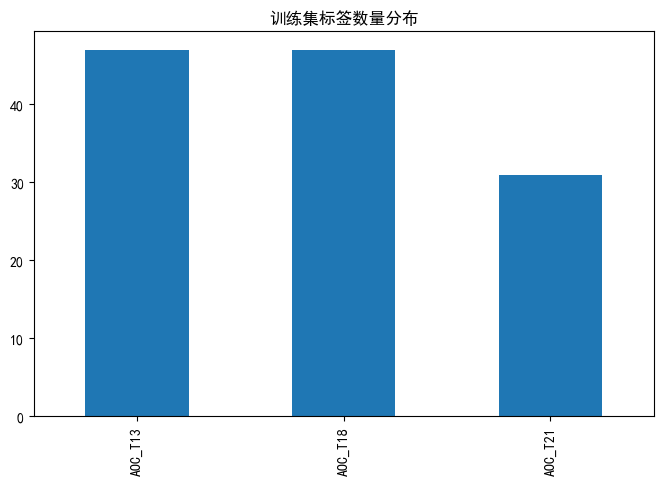

[saved] 模型参数 -> mlp_parameter_data/mlp_weighted_bce_opt_thresh.pth


C:\Users\Akuta\AppData\Local\Temp\ipykernel_15352\1962234394.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_weights = torch.tensor((neg_counts / (pos_counts + 1e-6)) * 0.5, dtype=torch.float32)


Epoch 10/200, Loss: 1.6670
Epoch 20/200, Loss: 1.6755
Epoch 30/200, Loss: 1.6887
Epoch 40/200, Loss: 1.6795
Epoch 50/200, Loss: 1.6737
Epoch 60/200, Loss: 1.6745
Epoch 70/200, Loss: 1.6726
Epoch 80/200, Loss: 1.6717
Epoch 90/200, Loss: 1.6705
Epoch 100/200, Loss: 1.6739
Epoch 110/200, Loss: 1.6819
Epoch 120/200, Loss: 1.6758
Epoch 130/200, Loss: 1.6609
Epoch 140/200, Loss: 1.6669
Epoch 150/200, Loss: 1.6892
Epoch 160/200, Loss: 1.6818
Epoch 170/200, Loss: 1.6757
Epoch 180/200, Loss: 1.6599
Epoch 190/200, Loss: 1.6799
Epoch 200/200, Loss: 1.6831
Best thresholds per label: [0.5 0.5 0.5]

=== 无过采样MLP + Weighted BCE + Optimized Threshold 模型评估指标 ===
Hamming Loss: 0.4848
Subset Accuracy: 0.0413
Precision (micro): 0.0757
Recall (micro): 0.7368
F1-score (micro): 0.1373
Precision (macro): 0.0871
Recall (macro): 0.6389
F1-score (macro): 0.1473


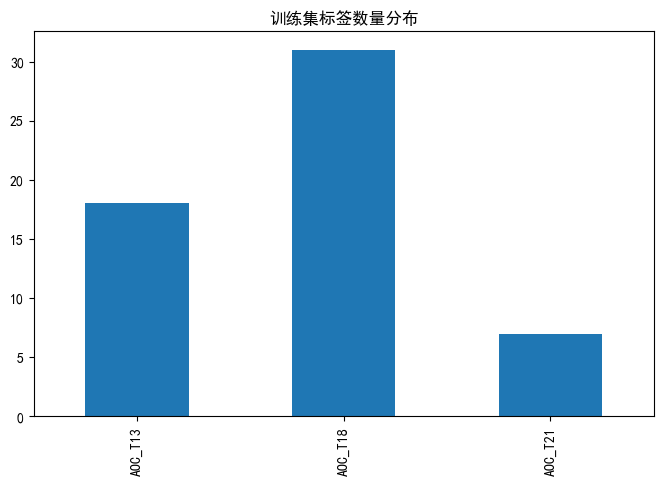

[saved] 模型参数 -> mlp_parameter_data/nomlp_weighted_bce_opt_thresh.pth


In [41]:


# ------------------ MLP 模型 ------------------
class MultiLabelMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLabelMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# ------------------ 自动搜索标签阈值 ------------------
def search_best_threshold(model, val_loader, y_val, thresholds=np.arange(0.1, 0.9, 0.05)):
    model.eval()
    all_logits = []
    with torch.no_grad():
        for batch_x, _ in val_loader:
            logits = model(batch_x)
            all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0).numpy()
    
    best_thresholds = []
    for i in range(y_val.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            pred_i = (all_logits[:, i] >= t).astype(int)
            f1 = f1_score(y_val[:, i], pred_i, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

# ------------------ 主流程 ------------------
if __name__ == "__main__":

    # 转换为 PyTorch Tensor
    X_val_selected = X_val[selected_feats].values
    train_dataset = TensorDataset(torch.tensor(train_x_res_scaled, dtype=torch.float32),
                                  torch.tensor(train_y_res.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val_selected, dtype=torch.float32),
                                torch.tensor(y_val.values, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(test_x_selected, dtype=torch.float32),
                                 torch.tensor(test_y.values, dtype=torch.float32))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # MLP 初始化
    input_dim = len(selected_feats)
    hidden_dim = 64
    output_dim = train_y_res.shape[1]
    
    model = MultiLabelMLP(input_dim, hidden_dim, output_dim)
    
    # 计算标签加权（微调比例避免过度预测）
    n_samples = train_y_res.shape[0]
    pos_counts = train_y_res.sum(axis=0)
    neg_counts = n_samples - pos_counts
    pos_weights = torch.tensor((neg_counts / (pos_counts + 1e-6)) * 0.5, dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # --------- 训练 ----------
    epochs = 200
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        epoch_loss /= n_samples
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    # --------- 搜索每个标签最优阈值 ----------
    best_thresholds = search_best_threshold(model, val_loader, y_val.values)
    print("Best thresholds per label:", best_thresholds)
    
    # --------- 测试预测 ----------
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch_x, _ in test_loader:
            logits = model(batch_x)
            preds = (torch.sigmoid(logits).numpy() >= best_thresholds).astype(int)
            all_preds.append(preds)
    all_preds = np.vstack(all_preds)
    
    # --------- 评估指标 ----------
    metrics = evaluate_multilabel(test_y.values, all_preds)
    print("\n=== MLP + Weighted BCE + Optimized Threshold 模型评估指标 ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False 
    plt.figure(figsize=(8,5))
    pd.DataFrame(train_y_res, columns=label_cols).sum(axis=0).plot(kind='bar', title='训练集标签数量分布')
    plt.show()
    
    # --------- 保存模型 ----------
    os.makedirs('mlp_parameter_data', exist_ok=True)
    torch.save(model.state_dict(), 'mlp_parameter_data/mlp_weighted_bce_opt_thresh.pth')
    print("[saved] 模型参数 -> mlp_parameter_data/mlp_weighted_bce_opt_thresh.pth")


# #无过采样
    train_dataset1 = TensorDataset(torch.tensor(train_x_selected, dtype=torch.float32),
                                  torch.tensor(train_y.values, dtype=torch.float32))
    val_dataset1 = TensorDataset(torch.tensor(X_val_selected, dtype=torch.float32),
                                torch.tensor(y_val.values, dtype=torch.float32))
    test_dataset1 = TensorDataset(torch.tensor(test_x_selected, dtype=torch.float32),
                                 torch.tensor(test_y.values, dtype=torch.float32))
    
    train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True)
    val_loader1 = DataLoader(val_dataset1, batch_size=32, shuffle=False)
    test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False)
    
    # MLP 初始化
    input_dim1 = len(selected_feats)
    hidden_dim1 = 64
    output_dim1 = train_y.shape[1]
    
    model1 = MultiLabelMLP(input_dim1, hidden_dim1, output_dim1)
    
    # 计算标签加权（微调比例避免过度预测）
    n_samples = train_y.shape[0]
    pos_counts = train_y.sum(axis=0)
    neg_counts = n_samples - pos_counts
    pos_weights = torch.tensor((neg_counts / (pos_counts + 1e-6)) * 0.5, dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # --------- 训练 ----------
    epochs = 200
    model1.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model1(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        epoch_loss /= n_samples
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    # --------- 搜索每个标签最优阈值 ----------
    best_thresholds1 = search_best_threshold(model1, val_loader, y_val.values)
    print("Best thresholds per label:", best_thresholds1)
    
    # --------- 测试预测 ----------
    model1.eval()
    all_preds1 = []
    with torch.no_grad():
        for batch_x, _ in test_loader:
            logits = model1(batch_x)
            preds = (torch.sigmoid(logits).numpy() >= best_thresholds).astype(int)
            all_preds1.append(preds)
    all_preds1 = np.vstack(all_preds1)
    
    # --------- 评估指标 ----------
    metrics1 = evaluate_multilabel(test_y.values, all_preds1)
    print("\n=== 无过采样MLP + Weighted BCE + Optimized Threshold 模型评估指标 ===")
    for k, v in metrics1.items():
        print(f"{k}: {v:.4f}")
    
    # --------- 标签分布可视化 ----------
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False 
    plt.figure(figsize=(8,5))
    pd.DataFrame(train_y, columns=label_cols).sum(axis=0).plot(kind='bar', title='训练集标签数量分布')
    plt.show()
    
    # --------- 保存模型 ----------
    os.makedirs('mlp_parameter_data', exist_ok=True)
    torch.save(model.state_dict(), 'mlp_parameter_data/nomlp_weighted_bce_opt_thresh.pth')
    print("[saved] 模型参数 -> mlp_parameter_data/nomlp_weighted_bce_opt_thresh.pth")

In [43]:
import os
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
from scipy.stats import uniform, randint


# ====== 多标签直方图梯度提升 + 自动调参 ======
def run_ml_histgb_autotune(train_x, train_y, test_x, test_y, n_iter=20):

    base_hgb = HistGradientBoostingClassifier(
        early_stopping=False,
        random_state=42
    )

    # 包装成多输出分类器
    multi_hgb = MultiOutputClassifier(base_hgb, n_jobs=-1)

    # 定义搜索空间（针对内部的 base_estimator 参数）
    param_distributions = {
        "estimator__learning_rate": uniform(0.01, 0.2),  # [0.01, 0.21)
        "estimator__max_iter": randint(100, 600),
        "estimator__max_depth": randint(3, 10),
        "estimator__l2_regularization": uniform(0.0, 1.0),
        "estimator__max_bins": randint(128, 255),
    }

    search = RandomizedSearchCV(
        multi_hgb,
        param_distributions=param_distributions,
        n_iter=n_iter,              # 随机采样次数
        scoring="f1_micro",         # 使用 micro F1 评价整体性能
        cv=3,                       # 3 折交叉验证
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # 开始搜索
    search.fit(train_x, train_y)

    print("最佳参数：")
    for k, v in search.best_params_.items():
        print(f"  {k}: {v}")

    best_model = search.best_estimator_

    # 在测试集上预测
    y_pred = best_model.predict(test_x)

    # Hamming Loss
    loss = hamming_loss(test_y.values, y_pred)
    print(f"MLHGB (AutoTune) Hamming Loss={loss:.4f}")

    # 评估指标
    metrics = evaluate_multilabel(test_y.values, y_pred)
    print("\n===梯度boosting评估指标 ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return best_model, y_pred, search.best_params_


if __name__ == "__main__":
    # ====== 含过采样数据实验 ======
    model, best_predict, best_params = run_ml_histgb_autotune(train_x_res_scaled, train_y_res, test_x_selected, test_y)

    os.makedirs('mlhgb_autotune_data', exist_ok=True)
    experiment_filepath = os.path.join('mlhgb_autotune_data', 'mlhgb_autotune_experiment.npz')

    np.savez_compressed(
        experiment_filepath,
        predict=best_predict,
        y_true=test_y.values,
        best_params=np.array(list(best_params.items()), dtype=object),
        hamming_loss=np.array([hamming_loss(test_y.values, best_predict)])
    )
    print(f"[saved] MLHGB 自动调参实验结果 -> {experiment_filepath}")


    # ====== 无过采样数据实验 ======
    model1, best_predict1, best_params1 = run_ml_histgb_autotune(train_x_selected, train_y, test_x_selected, test_y)

    os.makedirs('nomlhgb_autotune_data', exist_ok=True)
    experiment_filepath1 = os.path.join('nomlhgb_autotune_data', 'nomlhgb_autotune_experiment.npz')

    np.savez_compressed(
        experiment_filepath1,
        predict=best_predict1,
        y_true=test_y.values,
        best_params=np.array(list(best_params1.items()), dtype=object),
        hamming_loss=np.array([hamming_loss(test_y.values, best_predict1)])
    )
    print(f"[saved] 无过采样MLHGB 自动调参实验结果 -> {experiment_filepath1}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
最佳参数：
  estimator__l2_regularization: 0.01563640674119393
  estimator__learning_rate: 0.09468029614127392
  estimator__max_bins: 128
  estimator__max_depth: 6
  estimator__max_iter: 235
MLHGB (AutoTune) Hamming Loss=0.0689

===梯度boosting评估指标 ===
Hamming Loss: 0.0689
Subset Accuracy: 0.8347
Precision (micro): 0.2500
Recall (micro): 0.1579
F1-score (micro): 0.1935
Precision (macro): 0.1429
Recall (macro): 0.0833
F1-score (macro): 0.1053
[saved] MLHGB 自动调参实验结果 -> mlhgb_autotune_data\mlhgb_autotune_experiment.npz
Fitting 3 folds for each of 20 candidates, totalling 60 fits
最佳参数：
  estimator__l2_regularization: 0.5426960831582485
  estimator__learning_rate: 0.03818484499495253
  estimator__max_bins: 142
  estimator__max_depth: 7
  estimator__max_iter: 164
MLHGB (AutoTune) Hamming Loss=0.0523

===梯度boosting评估指标 ===
Hamming Loss: 0.0523
Subset Accuracy: 0.8678
Precision (micro): 0.5000
Recall (micro): 0.1579
F1-score (micro): 0.2400